# Overlap Score Demo
### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.image import imread
from typing import Tuple

from src.utils.read_write_dense import read_array
from src.utils.read_write_model import read_cameras_binary, read_images_binary, qvec2rotmat

In [3]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(18, 24))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()


def get_K_R_t(
    camera: namedtuple, 
    image: namedtuple,
    invert: bool = False,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # used https://github.com/colmap/colmap/blob/dev/scripts/python/visualize_model.py as a guide for this function

    # rotation
    R = qvec2rotmat(image.qvec)

    # translation
    t = image.tvec

    # intrinsics
    if camera.model in ("SIMPLE_PINHOLE", "SIMPLE_RADIAL", "RADIAL"):
        fx = fy = camera.params[0]
        cx = camera.params[1]
        cy = camera.params[2]
    elif camera.model in ("PINHOLE", "OPENCV", "OPENCV_FISHEYE", "FULL_OPENCV"):
        fx = camera.params[0]
        fy = camera.params[1]
        cx = camera.params[2]
        cy = camera.params[3]
    else:
        raise Exception("Camera model not supported")
    
    K = np.identity(3)
    K[0, 0] = fx
    K[1, 1] = fy
    K[0, 2] = cx
    K[1, 2] = cy

    # invert for backprojection
    if invert:
        t = -R.T @ t
        R = R.T
        K = np.linalg.inv(K)

    return K, R, t


### Computation of Overlap Score
Change the following image IDs to compute the overlap score of another image pair:

In [4]:
id_1 = 26
id_2 = 27

Let us plot the corresponding images and depth maps

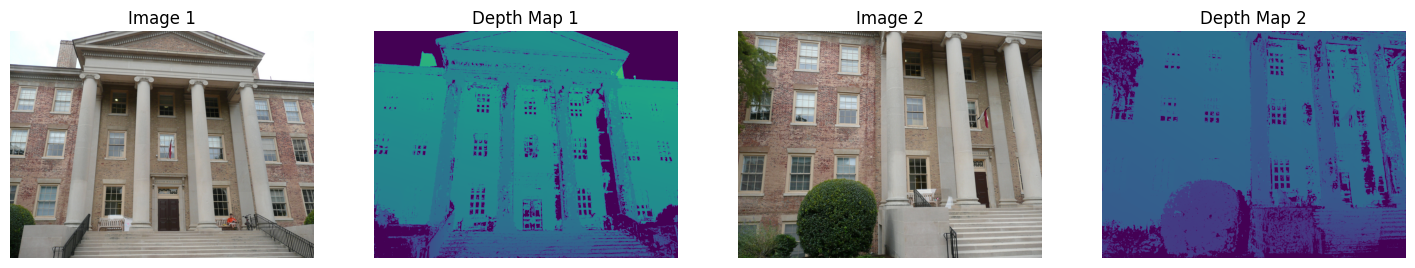

In [5]:
# output directory of the dense reconstruction pipeline
dense_dir = os.path.join("..", "MegaDepthData", "south-building", "dense", "0") 

# key: camera ID, value: camera model and parameters
camera_dict = read_cameras_binary(os.path.join(dense_dir, "sparse", "cameras.bin"))
# key: image ID, value: camera ID, camera pose, feature points
image_dict = read_images_binary(os.path.join(dense_dir, "sparse", "images.bin"))

name_1 = image_dict[id_1].name
name_2 = image_dict[id_2].name

img_1 = imread(os.path.join(dense_dir, "images", name_1))
img_2 = imread(os.path.join(dense_dir, "images", name_2))

depth_1 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{name_1}.geometric.bin"))
depth_2 = read_array(os.path.join(dense_dir, "stereo", "depth_maps", f"{name_2}.geometric.bin"))

plot_images([img_1, depth_1, img_2, depth_2], ["Image 1", "Depth Map 1", "Image 2", "Depth Map 2"])

For each pixel **p1** in image 1:
1. If **d1** is a valid depth value, backproject **p1** to 3D space to obtain point **P** with distance **d1** from camera 1.
2. Project **P** to the image space of the image 2 to get pixel coordinates **(x, y)**.
3. If pixel **(x, y)** lies inside image 2 and the depth value **d2** at **(x, y)** is a valid depth value, check if it roughly equals to the distance between **P** and camera 2.

In [6]:
image_1 = image_dict[id_1]
image_2 = image_dict[id_2]

camera_1 = camera_dict[image_1.camera_id]
camera_2 = camera_dict[image_2.camera_id]

K1, R1, t1 = get_K_R_t(camera=camera_1, image=image_1, invert=True)
K2, R2, t2 = get_K_R_t(camera=camera_2, image=image_2, invert=False)

total_pixels = camera_1.height * camera_1.width
overlap_count = 0

for h in range(camera_1.height):
    for w in range(camera_1.width):
        if depth_1[h, w] == 0.0:
            continue
        
        # backproject
        p1 = np.array([h, w, 1]) # TODO: not sure yet if [w, h, 1] or [h, w, 1] is correct...
        P = R1 @ (K1 @ p1) + t1 
        
        # make sure that ||camera1 - P|| = depth_1[h, w]
        P = P / np.linalg.norm(image_1.tvec) * depth_1[h, w]

        # project it to the image space of camera 2
        p2 = K2 @ (R2 @ P + t2)

        # pixel coordinates of p2 in image 2
        # TODO: Check if p2 needs to be normalized first such that the 3rd component is 1
        x = int(p2[0]) # TODO: not sure yet about order of x and y...
        y = int(p2[1])

        if x < 0 or x >= camera_2.height or y < 0 or y >= camera_2.width:
            continue
        
        # check if distance approximately matches with actual depth value
        distance = np.linalg.norm(P - t2)
        if distance > 0.98 * depth_2[x, y] and distance < 1.02 * depth_2[x, y]:
            overlap_count += 1

overlap_score = overlap_count / total_pixels       
overlap_score

0.0003522959657928983